In [199]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [200]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/21h7/s_yaw_21h7_5m_720_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [201]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [202]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,1.189821
1,0.606128,1.924495
2,1.170165,-4.961781
3,1.851375,6.489528
4,2.635831,-1.089488
...,...,...
309,70.906390,62.751519
310,73.472157,-13.915198
311,77.547951,-35.866486
312,85.068977,23.250225


In [203]:
df = df.drop(df[df.yaw < -15].index).reset_index()

<AxesSubplot:xlabel='relative_time'>

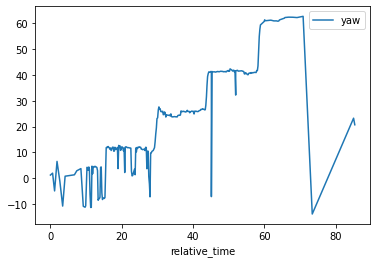

In [204]:
# initial graph
df.plot(x='relative_time', y=target)

In [205]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 15)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [206]:
# the amount of data points we are left with
len(x[peaks])

75

In [207]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

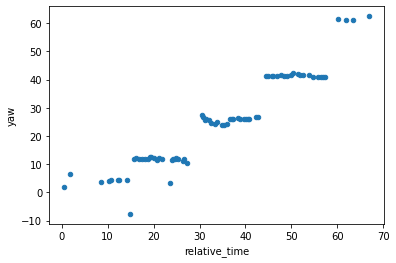

In [208]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [209]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)

In [210]:
# remove errors as they are not really outliers
a = df_filtered_by_targets.true_yaw
df_filtered_by_targets.drop(a.loc[(a.diff() > 10) & (a.diff(periods=-1) > 10)].index, inplace=True)

/tmp/ipykernel_8582/2189345900.py:3: FutureWarning: dtype lost in 'diff()'. In the future this will raise a TypeError. Convert to a suitable dtype prior to calling 'diff'.
  df_filtered_by_targets.drop(a.loc[(a.diff() > 10) & (a.diff(periods=-1) > 10)].index, inplace=True)


In [211]:
# show all
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,index,relative_time,yaw,true_yaw
1,1,0.606128,1.924495,0
9,10,8.554126,3.697675,0
14,15,10.257835,4.201289,0
17,19,10.772422,4.323643,0
25,27,12.169112,4.473599,0
27,29,12.514616,4.599405,0
37,39,14.253148,4.343261,0
41,43,14.962030,-7.630293,0
46,48,15.835566,12.013706,15
48,50,16.184971,12.274780,15


In [212]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [213]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [214]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(2)

,index,relative_time,yaw,true_yaw,error
41,43,14.962030,-7.630293,0,7.630293
87,91,23.600090,3.464743,0,-3.464743
105,109,26.719705,11.960736,15,3.039264
108,112,27.236275,10.458875,15,4.541125
190,195,42.204284,26.653000,30,3.347000
193,198,42.722690,26.920783,30,3.079217
269,281,56.832196,40.956187,45,4.043813
272,284,57.348444,41.049489,45,3.950511
285,298,63.422347,60.991591,60,-0.991591
293,306,66.833684,62.431096,60,-2.431096


In [215]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,9.0,-2.599757,3.923485,-4.599405,-4.343261,-4.201289,-3.464743,7.630293
15,20.0,3.086803,0.461995,2.309513,2.889285,3.033826,3.197562,4.541125
30,22.0,4.295066,0.988742,2.373994,3.966479,4.068836,4.886756,6.194339
45,19.0,3.613511,0.399474,2.613469,3.366823,3.627122,3.875015,4.223402
60,4.0,-1.522660,0.629044,-2.431096,-1.657430,-1.333976,-1.199206,-0.991591


In [216]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

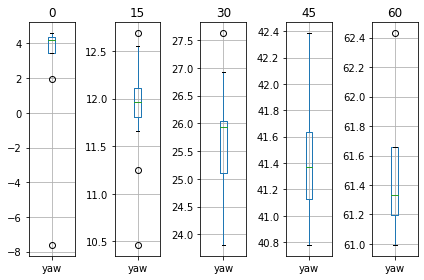

In [217]:
box_plotter(target)

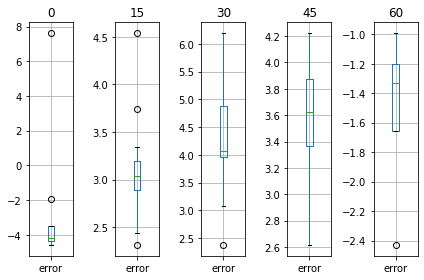

In [218]:
box_plotter('error')